In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import graph_analysis, data_preprocessing

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## Examining structural connectivity in neonates at genetic risk for schizophrenia

In [77]:
! ls preprocessed_data/

Imperial_GM_labels.npy
adjusted_european_GM_volumetric_Imperial_matrix.npy
adjusted_european_PRS_schizophrenia.npy
adjusted_european_volumetric_AAL_matrix.npy
adjusted_european_volumetric_Imperial_matrix.npy
european_PRS_schizophrenia.npy
graph_metrics_vol_high_risk.txt
graph_metrics_vol_low_risk.txt
high_low_risk_vol_dataset.npy


In [85]:
# importing the preprocessed data
adjusted_european_GM_volumetric_Imperial_matrix=np.load('./preprocessed_data/adjusted_european_GM_volumetric_Imperial_matrix.npy')
Imperial_GM_labels=np.load('./preprocessed_data/Imperial_GM_labels.npy',allow_pickle=True)
adjusted_european_volumetric_AAL_matrix=np.load('./preprocessed_data/adjusted_european_volumetric_AAL_matrix.npy',allow_pickle=True)
european_PRS_schizophrenia=np.load('./preprocessed_data/european_PRS_schizophrenia.npy',allow_pickle=True)
AAL_label=np.load('./preprocessed_data/AAL_label.npy',allow_pickle=True)

### 1.1 Imperial GM atlas

In [66]:
#Dividing the data set into high and low risk
#get the indices of the low and high risk
low_risk,high_risk=data_preprocessing.high_low_risk_divide(european_PRS_schizophrenia[:,7],bins=100,percentage=0.3)
X_low_risk=adjusted_european_GM_volumetric_Imperial_matrix[low_risk,:]
X_high_risk=adjusted_european_GM_volumetric_Imperial_matrix[high_risk,:]
X=np.vstack((X_low_risk,X_high_risk))
X=StandardScaler().fit_transform(X)
y=np.concatenate((np.zeros(X_low_risk.shape[0]),np.ones(X_high_risk.shape[0])))

In [67]:
np.save('./preprocessed_data/high_low_risk_vol_dataset.npy',X)

#### 1.2 Visualising data

In [68]:
#rearrange the matrix by side
right_indices=np.array([idx for idx,i in enumerate(Imperial_GM_labels) if 'right' in i])
print(right_indices.shape)
left_indices=np.array([idx for idx,i in enumerate(Imperial_GM_labels) if 'left' in i])
print(left_indices.shape)
neither_indices=np.array([idx for idx,i in enumerate(Imperial_GM_labels) if 'right' not in i and 'left' not in i])
rearrange_by_side_indices=np.concatenate((right_indices,left_indices,neither_indices),axis=0)

(25,)
(25,)


In [69]:
# calculating pearson correlation matrix of volumetric data
corrmatrix_low_risk=abs(np.corrcoef(X[y==0,:],rowvar=False))
np.fill_diagonal(corrmatrix_low_risk,0)
corrmatrix_high_risk=abs(np.corrcoef(X[y==1,:],rowvar=False))
np.fill_diagonal(corrmatrix_high_risk,0)

In [70]:
rearranged_corrmatrix_low_risk=np.asarray([[corrmatrix_low_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_high_risk=np.asarray([[corrmatrix_high_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

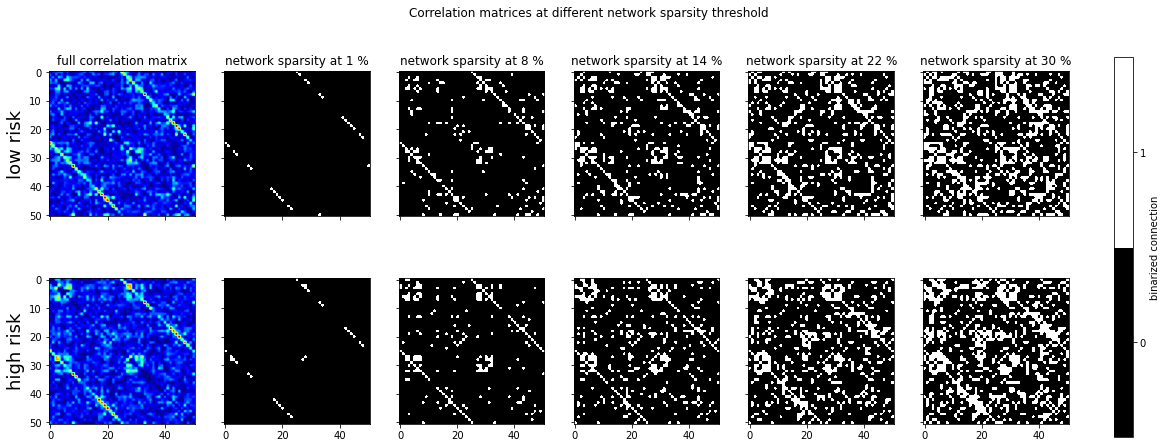

In [71]:
f,axes=plt.subplots(2,6,sharex=True,sharey=True,figsize=(20,7))
network_sparsity_threshold=[int(i) for i in (np.linspace(1,30,5))]
for idx,ax in enumerate(axes[0]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_low_risk,cmap='jet')
        ax.set_title('full correlation matrix')
        ax.set_ylabel('low risk',fontsize=18)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_low_risk,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        ax.set_title('network sparsity at %d %%'%(len(np.where(data_preprocessing.lower_triangle(binarized_matrix)==1)[0])*100/(52*51/2)))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[1]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_high_risk,cmap='jet')
        ax.set_ylabel('high risk',fontsize=18)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_high_risk,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

f.suptitle('Correlation matrices at different network sparsity threshold')
f.colorbar(im,ax=np.concatenate(axes),ticks=range(2),label='binarized connection',fraction=0.046, pad=0.04)

#### 1.3 Network metrics

In [72]:
#generate binarized matrices for over a range of network sparsity for high and low risk groups
binarized_low_risk_matrices=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])
binarized_high_risk_matrices=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])

In [73]:
!rm preprocessed_data/graph_metrics_vol_*_risk.txt

In [74]:
#calculating graph_metrics_low_risk
import tqdm

for threshold in tqdm.tqdm(range(30)):
    temp_path_low_risk='./preprocessed_data/graph_metrics_vol_low_risk.txt'
    low_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_low_risk_matrices[threshold],51))

    with open(temp_path_low_risk,'ab') as f:
        np.savetxt(f,np.asarray([low_risk_metrics]),delimiter='\t')

    temp_path_high_risk='./preprocessed_data/graph_metrics_vol_high_risk.txt'
    high_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_high_risk_matrices[threshold],51))

    with open(temp_path_high_risk,'ab') as n:
        np.savetxt(n,np.asarray([high_risk_metrics]),delimiter='\t')

100%|██████████| 30/30 [02:45<00:00,  5.52s/it]


#### 1.4 Permutation statistics

In [6]:
#run executable_script/perm_graph_network.py to calculate 1000 permuted network metrics.
obsv_high=np.loadtxt('./preprocessed_data/graph_metrics_vol_high_risk.txt')
obsv_low=np.loadtxt('./preprocessed_data/graph_metrics_vol_low_risk.txt')

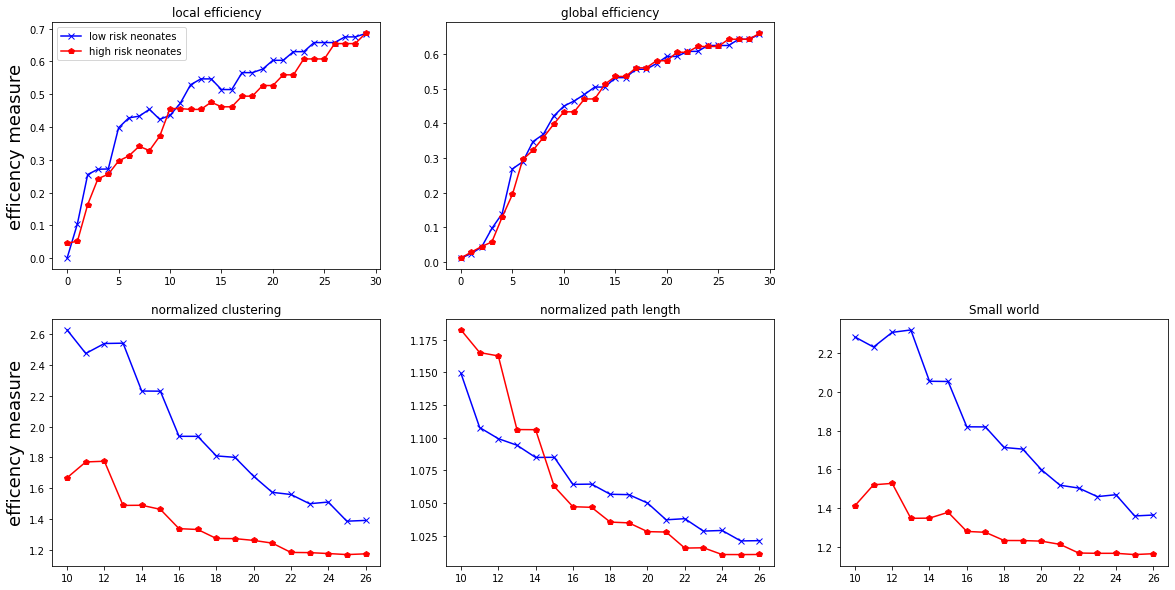

In [20]:
##############LOCAL EFFICIENCY############################
f,axes=plt.subplots(2,3,figsize=(20,10))
axes[0][0].plot(obsv_low[:,0],'x-',color='blue',label='low risk neonates')
axes[0][0].plot(obsv_high[:,0],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_local_eff:
#     axes[0][0].annotate(' ',xy=(idx,obsv_high[:,0][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[0][0].legend(loc='bottom right')
axes[0][0].set_title('local efficiency')
axes[0][0].set_ylabel('efficency measure',fontsize=18)
##############GLOBAL EFFICIENCY############################
axes[0][1].plot(obsv_low[:,1],'x-',color='blue',label='low risk neonates')
axes[0][1].plot(obsv_high[:,1],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_global_eff:
#     axes[0][1].annotate(' ',xy=(idx,obsv_high[:,1][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[0][1].set_title('global efficiency')
# axes[0][1].set_ylabel('efficency measure',fontsize=18)
##############NORMALIZED CLUSTERING############################
axes[1][0].plot(np.linspace(10,26,17),obsv_low[9:26,2],'x-',color='blue',label='low risk neonates')
axes[1][0].plot(np.linspace(10,26,17),obsv_high[9:26,2],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_clus_eff:
#     if idx==0:
#         continue
#     axes[1][0].annotate(' ',xy=(idx,obsv_high[:,2][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[1][0].set_title('normalized clustering')
axes[1][0].set_ylabel('efficency measure',fontsize=18)
# ##############NORMALIZED PATH############################
axes[1][1].plot(np.linspace(10,26,17),obsv_low[9:26,3],'x-',color='blue',label='low risk neonates')
axes[1][1].plot(np.linspace(10,26,17),obsv_high[9:26,3],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_path_eff:
#     if idx==0:
#         continue
#     axes[1][1].annotate(' ',xy=(idx,obsv_high[:,3][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[1][1].set_title('normalized path length')
# axes[1][1].set_ylabel('efficency measure',fontsize=18)
##############SMALL WORDNESS############################
axes[1][2].plot(np.linspace(10,26,17),obsv_low[9:26,4],'x-',color='blue',label='low risk neonates')
axes[1][2].plot(np.linspace(10,26,17),obsv_high[9:26,4],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_small_eff:
#     if idx==0:
#         continue
#     axes[1][2].annotate(' ',xy=(idx,obsv_high[:,4][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[1][2].set_title('Small world')
# axes[1][2].set_ylabel('efficency measure',fontsize=18)

f.delaxes(ax=axes[0,2])

### 2.1 AAL atlas

In [118]:
#Dividing the data set into high and low risk
#get the indices of the low and high risk
low_risk,high_risk=data_preprocessing.high_low_risk_divide(european_PRS_schizophrenia[:,7],bins=100,percentage=0.3)
X_low_risk=adjusted_european_volumetric_AAL_matrix[low_risk,:]
X_high_risk=adjusted_european_volumetric_AAL_matrix[high_risk,:]
X=np.vstack((X_low_risk,X_high_risk))
X=StandardScaler().fit_transform(X)
y=np.concatenate((np.zeros(X_low_risk.shape[0]),np.ones(X_high_risk.shape[0])))

In [119]:
np.save('./preprocessed_data/high_low_risk_vol_AAL_dataset.npy',X)

### 2.2 Visualising

In [99]:
#rearrange the matrix by side
right_indices=np.array([idx for idx,i in enumerate(AAL_label) if '_R' in i])
print(right_indices.shape)
left_indices=np.array([idx for idx,i in enumerate(AAL_label) if '_L' in i])
left_indices=np.delete(left_indices,np.where(left_indices==69)[0])#removed the paracentral_lobuble_r
print(left_indices.shape)
neither_indices=np.array([idx for idx,i in enumerate(AAL_label) if '_R' not in i and '_L' not in i])
rearrange_by_side_indices=np.concatenate((right_indices,left_indices,neither_indices),axis=0)

(46,)
(46,)


In [101]:
# calculating pearson correlation matrix of volumetric data
corrmatrix_low_risk=abs(np.corrcoef(X[y==0,:],rowvar=False))
np.fill_diagonal(corrmatrix_low_risk,0)
corrmatrix_high_risk=abs(np.corrcoef(X[y==1,:],rowvar=False))
np.fill_diagonal(corrmatrix_high_risk,0)

In [102]:
rearranged_corrmatrix_low_risk=np.asarray([[corrmatrix_low_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_high_risk=np.asarray([[corrmatrix_high_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

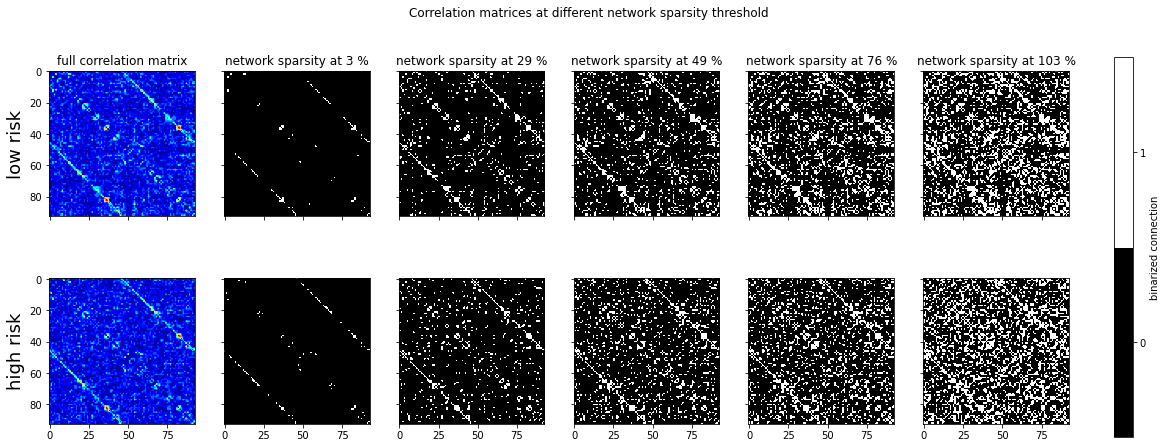

In [103]:
f,axes=plt.subplots(2,6,sharex=True,sharey=True,figsize=(20,7))
network_sparsity_threshold=[int(i) for i in (np.linspace(1,30,5))]
for idx,ax in enumerate(axes[0]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_low_risk,cmap='jet')
        ax.set_title('full correlation matrix')
        ax.set_ylabel('low risk',fontsize=18)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_low_risk,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        ax.set_title('network sparsity at %d %%'%(len(np.where(data_preprocessing.lower_triangle(binarized_matrix)==1)[0])*100/(52*51/2)))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[1]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_high_risk,cmap='jet')
        ax.set_ylabel('high risk',fontsize=18)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_high_risk,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

f.suptitle('Correlation matrices at different network sparsity threshold')
f.colorbar(im,ax=np.concatenate(axes),ticks=range(2),label='binarized connection',fraction=0.046, pad=0.04)

In [104]:
#generate binarized matrices for over a range of network sparsity for high and low risk groups
binarized_low_risk_matrices=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])
binarized_high_risk_matrices=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])

In [105]:
#calculating graph_metrics_low_risk
import tqdm

for threshold in tqdm.tqdm(range(30)):
    temp_path_low_risk='./preprocessed_data/graph_metrics_vol_AAL_low_risk.txt'
    low_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_low_risk_matrices[threshold],51))

    with open(temp_path_low_risk,'ab') as f:
        np.savetxt(f,np.asarray([low_risk_metrics]),delimiter='\t')

    temp_path_high_risk='./preprocessed_data/graph_metrics_vol_AAL_high_risk.txt'
    high_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_high_risk_matrices[threshold],51))

    with open(temp_path_high_risk,'ab') as n:
        np.savetxt(n,np.asarray([high_risk_metrics]),delimiter='\t')

100%|██████████| 30/30 [03:22<00:00,  6.73s/it]


In [14]:
#run executable_script/perm_graph_network.py to calculate 1000 permuted network metrics.
obsv_high=np.loadtxt('./preprocessed_data/graph_metrics_vol_AAL_high_risk.txt')
obsv_low=np.loadtxt('./preprocessed_data/graph_metrics_vol_AAL_low_risk.txt')

In [15]:
import glob
perm_high,perm_low=graph_analysis.preprocess_perm_graph_results(shape=(-1,30,5),high_risk=sorted(glob.glob('./log/*high*run*')),low_risk=sorted(glob.glob('./log/*low*run*')))

the two list do not have the same length: ./log/perm_graph_metrics_AAL_high_risk_vm4_run1.txt and ./log/perm_graph_metrics_AAL_low_risk_vm4_run1.txt


In [17]:
p_value_matrix=graph_analysis.calculate_perm_p_value(obsv_high,obsv_low,perm_high,perm_low)

In [18]:
sig_indices_local_eff=np.where(p_value_matrix[:,0]<=0.025)[0]
sig_indices_global_eff=np.where(p_value_matrix[:,1]<=0.025)[0]
sig_indices_clus_eff=np.where(p_value_matrix[:,2]<=0.025)[0]
sig_indices_path_eff=np.where(p_value_matrix[:,3]<=0.025)[0]
sig_indices_small_eff=np.where(p_value_matrix[:,4]<=0.025)[0]

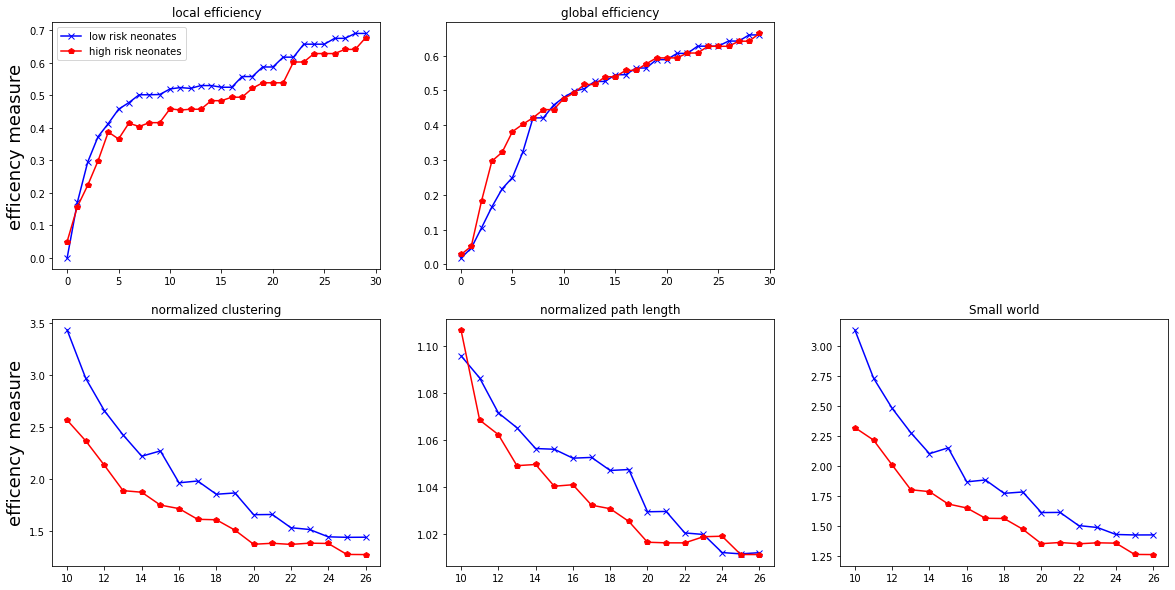

In [62]:
##############LOCAL EFFICIENCY############################
f,axes=plt.subplots(2,3,figsize=(20,10))
axes[0][0].plot(obsv_low[:,0],'x-',color='blue',label='low risk neonates')
axes[0][0].plot(obsv_high[:,0],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_local_eff:
#     axes[0][0].annotate(' ',xy=(idx,obsv_high[:,0][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[0][0].legend(loc='bottom right')
axes[0][0].set_title('local efficiency')
axes[0][0].set_ylabel('efficency measure',fontsize=18)
##############GLOBAL EFFICIENCY############################
axes[0][1].plot(obsv_low[:,1],'x-',color='blue',label='low risk neonates')
axes[0][1].plot(obsv_high[:,1],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_global_eff:
#     axes[0][1].annotate(' ',xy=(idx,obsv_high[:,1][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[0][1].set_title('global efficiency')
# axes[0][1].set_ylabel('efficency measure',fontsize=18)
##############NORMALIZED CLUSTERING############################
axes[1][0].plot(np.linspace(10,26,17),obsv_low[9:26,2],'x-',color='blue',label='low risk neonates')
axes[1][0].plot(np.linspace(10,26,17),obsv_high[9:26,2],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_clus_eff:
#     if idx==0:
#         continue
#     axes[1][0].annotate(' ',xy=(idx,obsv_high[:,2][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[1][0].set_title('normalized clustering')
axes[1][0].set_ylabel('efficency measure',fontsize=18)
# ##############NORMALIZED PATH############################
axes[1][1].plot(np.linspace(10,26,17),obsv_low[9:26,3],'x-',color='blue',label='low risk neonates')
axes[1][1].plot(np.linspace(10,26,17),obsv_high[9:26,3],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_path_eff:
#     if idx==0:
#         continue
#     axes[1][1].annotate(' ',xy=(idx,obsv_high[:,3][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[1][1].set_title('normalized path length')
# axes[1][1].set_ylabel('efficency measure',fontsize=18)
##############SMALL WORDNESS############################
axes[1][2].plot(np.linspace(10,26,17),obsv_low[9:26,4],'x-',color='blue',label='low risk neonates')
axes[1][2].plot(np.linspace(10,26,17),obsv_high[9:26,4],'p-',color='red',label='high risk neonates')
# for idx in sig_indices_small_eff:
#     if idx==0:
#         continue
#     axes[1][2].annotate(' ',xy=(idx,obsv_high[:,4][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[1][2].set_title('Small world')
# axes[1][2].set_ylabel('efficency measure',fontsize=18)

f.delaxes(ax=axes[0,2])